## Bibliotecas utilizadas

Pandas: Dataframes e Series, para tratamento de dados tabelados.
Numpy: Para funções e utilidades matemáticas
Matplotlib: Para plotar gráficos (pyplot) e esquemas de cores (cm)
Axes3D: Para gráficos 3D

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx

## Objeto Test

### Atributos

- `name`: local e nome do arquivo do ensaio usado para adquirir os dados. Inicia como `'default'` e é settado depois pelo usuário.
- `f`: frequência utilizada no ensaio. Inicia como `None` e é settado depois pelo usuário.
- `data`: pandas.DataFrame com os dados do ensaio. Inicia com um DataFrame vazio e é settado depois pelo usuário
- `F`: Força normal utilizada no ensaio. Não é iniciada até que o método setForce seja usado pelo usuário
- `zero`: Tempo para o qual á reversão da velocidade (v = 0, x = +/-stroke/2). Não é iniciado até haver um setData.
- `meanCOF` e `stdCOF`: média e desvio padrão do coeficiente  de atrito, obtidos após setData e utilizando o método de avaliação do coeficiente de atrito apenas enquanto V >= V média. O maior valor de COF entre o obtido no deslizamento em uma direção ou outra.

### Métodos
- `__init__` : Ao inicializar o objeto, o nome padrão é `default`, a frequência padrão é `None` e os dados padrão são um DataFrame vazio.
- `__str__`: Ao chamar um `print()`, mostra um string multilinha com as informações básicas do ensaio (nome, COF médio, desv. pad. do COF, força normal, frequência, distância de deslizamento e tamanho de stroke.
- setters: para nome, frequência e força, apenas aplicam o valor passado para o atributo. Para data, vai pegar os dados relevantes (tempo e COF), definir onde está o ponto de velocidade zero, adicionar colunas de velocidade e posição e atribuir valores de COF médio e desvio padrão do COF.
- getters: para nome, frequência, força, dados e cof (tuple médio e desvio padrão) apenas retornam os valores destas variáveis. getSize retorna o tamanho em número de linhas do DataFrame do ensaio, getDuration retorna o tempo de ensaio em segundos, getDistance retorna a distância em milímetros total de deslizamento, getVmed calcula e retorna a velocidade média do ensaio, getupperdata retorna um DataFrame com os pontos em que V>=Vmed, getlowerdata retorna um DataFrame com os pontos em que V<=-Vmed, getHighCOFdata retorna o getupperdata ou o getlowerdata, dependendo de qual tiver o maior COF médio, getHighCOFstat retorna as estatísticas de getHighCOFdata.
- `plotTriboscopy`: Plota um gráfico 3D, com x sendo a posição do identador; y é o tempo de ensaio; z é o coeficiente de atrito
- `plotLastTime`: Plota um gráfico 2D, com x sendo o tempo de ensaio (parâmetro é últimos `time` segundos de ensaio) e y o coeficiente de atrito.
- `plotLastCycle`: Plota um gráfico como o `plotLastTime`, mas o usuário escolhe o número de ciclos do fim do ensaio em vez do tempo.

In [38]:
class test(object):
    def __init__ (self,name='default',f=None,df=pd.DataFrame()): #o ensaio é inicializado com nome default, freq None e dataframe vazio
        self.name = name
        self.f = f
        self.data = df
    def __str__ (self):
        string = """Ensaio: {}
COF: {:.4f} +/- {:.4f}
Força Normal: {:.1f} N
Frequência: {:.1f} Hz
Distância Total de Deslizamento: {:.1f} mm
Stroke: 4.66 mm
""".format(self.name,float(self.meanCOF),float(self.stdCOF),float(self.getForce()),
                float(self.getFrequency()),float(self.getDistance()))
        return string
    def __repr__ (self):
        return str(self)
      
    def setName(self,name): #setter para string com local/nome do arquivo original
        self.name = name
    def setFrequency(self,f): #setter para a frequência do ensaio
        self.f = f
    def setForce(self,F): #setter para a força do ensaio
        self.F = F
    def setData(self,dataseries): #setter para o dataframe de dados do ensaio
        self.data = dataseries.filter(items=['T','COF']) #dados originais, considerando apenas tempo e COF
        self.zero = self.data.tail(n = self.getSize()//2).nsmallest(1,'COF').iat[0,0] 
        #encontra onde está o COF=0 (reversão de velocidade)
        self.data = self.data.assign(V = - 4.66 * np.pi * self.f * np.sin((2.*np.pi*self.f*
                                                               (self.data['T'] 
                                                               - self.zero))),
                                     X = 4.66 * np.cos(2.*np.pi*self.f*
                                                       (self.data['T']-self.zero)))
        #atribui duas novas colunas: X, com a posição em relação ao MHS. V, com a velocidade instantânea de deslizamento
        self.meanCOF = self.getHighCOFstat().at['mean','COF'] #Calcula e salva o cof médio para o ensaio
        self.stdCOF = self.getHighCOFstat().at['std','COF'] #Calcula e salva o desvio padrão do cof para o ensaio
    
    def getName(self): #retorna o local/nome do arquivo do ensaio
        return self.name
    def getFrequency(self): #retorna um float com a frequência usada no ensaio
        return self.f
    def getForce(self): #retorna um float com a força usada no ensaio
        return self.F
    def getData(self): #retorna um dataframe com os dados de ensaio
        return self.data
    def getCOF(self): #retorna uma lista com [COF médio, desv pad do COF]
        COF = [self.meanCOF,self.stdCOF]
        return COF
    def getSize(self): #retorna um int do número de pontos do ensaio
        size = self.data.shape[0]
        return size
    def getDuration(self): #retorna um float da duração do ensaio em segundos
        duration = self.data['T'].max()
        return duration
    def getDistance(self): #retorna um float da distância, em milímetros, total do ensaio
        d = self.getFrequency() * 2 * 4.66 * (self.getDuration())
        return d
    def getVmed(self): #retorna um float da velocidade média do ensaio em milímetros por segundo
        Vmed = self.getDistance() / self.getDuration()
        return Vmed
    def getupperdata(self): #retorna um dataframe dos pontos acima da velocidade média
        self.ud = self.data[self.data.V >= self.getVmed()]
        return self.ud
    def getlowerdata(self): #retorna um dataframe dos pontos abaixo da velocidade média negativa
        self.ld = self.data[self.data.V <= -self.getVmed()]
        return self.ld
    def getHighCOFdata(self): #retorna um dataframe dos pontos cujo coeficiente de atrito médio é mais alto
        A = self.getupperdata()[self.getupperdata()['T']>=0.75*float(self.getDuration())]
        B = self.getlowerdata()[self.getlowerdata()['T']>=0.75*float(self.getDuration())]
        if (A.describe().at['mean','COF']>=B.describe().at['mean','COF']):
            return A
        else:
            return B
    def getHighCOFstat(self): #retorna um dataframe das estatísticas dos pontos cujo coeficiente de atrito médio é mais alto
        return self.getHighCOFdata().describe()
        
    def plotTriboscopy(self): #envia os parametros corretos para plotagem do gráfico triboscópico
        def scatter3d(x,y,z, cs, colorsMap='coolwarm'): #plota o gráfico triboscópico
            cm = plt.get_cmap(colorsMap)
            cNorm = cmx.colors.Normalize(vmin=min(cs), vmax=max(cs))
            scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x, y, z, c=scalarMap.to_rgba(cs),s=0.1,)
            ax.set_zlabel('COF')
            ax.set_zlim(0,0.5)
            ax.set_ylabel('Time')
            ax.set_xlabel('Position')
            ax.xaxis.labelpad=20
            ax.yaxis.labelpad=20
            ax.zaxis.labelpad=20
            ax.dist = 13
            scalarMap.set_array(cs)
            fig.colorbar(scalarMap, shrink = 0.8)
            plt.savefig(self.getName()[:-4]+'_trgraph.png',dpi=300)
        
        scatter3d(self.data['X'],self.data['T'],self.data['COF'],self.data['COF'])
    
    def plotLastTime(self,time): #plota o gráfico do coeficiente de atrito em funcao do tempo para os ultimos 'time' segundos
        self.data.tail(n=int(time*1000)).plot(kind='scatter',x='T',y='COF',s=0.1,ylim=[0,0.5],color='blue')
        plt.savefig(self.getName()[:-4]+'_timegraph.png',dpi=300)
    def plotLastCycle(self,cycle): #plota o gráfico do coeficiente de atrito em função do tempo para os ultimos 'cycle' ciclos
        time = cycle/self.getFrequency()
        self.data.tail(n=int(time*1000)).plot(kind='scatter',x='T',y='COF',s=0.1,ylim=[0,0.5],color='red')
        plt.savefig(self.getName()[:-4]+'_cyclegraph.png',dpi=300)

## Funções auxiliares
- `createTestList`: cria uma lista `[]` de objetos `test` com cada ensaio no `local/material/nome_###` indicados. Usa as funções `findData`, `findFrequency` e `findForce` para abrir os csvs e conseguir estas variáveis
- `findData`: abre o csv com determinado `filename`, com a função `read_csv` do Pandas. Ignora o cabeçalho dos arquivos
- `findFrequency`: abre o csv e vasculha o cabeçalho em busca da frequência, que é gravada pelo tribômetro como Velocity
- `findForce`: abre o csv e vasculha o cabeçalho em busca da força, que é gravada pelo tribômetro como Set Force

In [39]:
def createTestList(local,material,nome,inicio,fim): #abre os CSVs e armazena numa lista de ensaios
    """
    abre os arquivos .csv na string 'local', string 'nome', desde o índice de
    arquivo _00 inicio até _ fim. Somente importa as colunas passadas na lista
    de inteiros colunas
    """
    testlist = []
    for i in range(fim-inicio+1):
        test_i = test()
        if i<=8:
            filename = local+'/'+material+'/'+nome+'_00'+str(i+1)+'.csv'
        elif i<=98:
            filename = local+'/'+material+'/'+nome+'_0'+str(i+1)+'.csv'
        else:
            filename = local+'/'+material+'/'+nome+'_'+str(i+1)+'.csv'
        test_i.setName(filename)
        try:
            test_i.setFrequency(findFrequency(filename))
            test_i.setForce(findForce(filename))
            test_i.setData(findData(filename))
        except FileNotFoundError:
            print("Arquivo <"+filename+"> não encontrado.")
            test_i = None
        testlist.append(test_i)
    return testlist

def findData(filename): #abre o CSV para recuperar os dados de ensaio, ignorando o cabeçalho
    return pd.read_csv(filename, header=17, skiprows = [21],
                        dtype = {'T': np.float64,'COF': np.float64})

def findFrequency(filename): #abre o CSV para recuperar a frequência do ensaio a partir do cabeçalho
    A = pd.read_csv(filename, sep='\n', skiprows=13, nrows=5, names=["Dados"])
    linha = A.at[1, "Dados"]
    l = linha.replace(' ','')
    ldic = locals()
    exec(l, globals(), ldic)
    Velocity = ldic["Velocity"]
    return Velocity

def findForce(filename): #abre o CSV para recuperar a força do ensaio a partir do cabeçalho
    A = pd.read_csv(filename, sep='\n', skiprows=13, nrows=5, names=["Dados"])
    linha = A.at[2, "Dados"]
    l = linha.replace(' ','')
    ldic = locals()
    exec(l, globals(), ldic)
    F = ldic["SetForce"]
    return -F
    

## Local dos dados
`local`: string com a pasta que contém os arquivos `*.csv` dos ensaios

In [40]:
#DADOS ENTRADA
local = 'C:/Users/caiot/OneDrive/Documentos/Python/Results/CSV'

## Criação de listas de ensaios

In [41]:
#Listas de dados brutos
print('Carregando dados...')
PUFC = createTestList(local,'PU_FC','PU_fatorial',1,24)
PU = createTestList(local,'PU','PV_Limite',1,12)
PUEG1 = createTestList(local,'PUEG1','PV_Limite',1,12)
PUEG2 = createTestList(local,'PUEG2','PV_Limite',1,12)
print('Dados carregados com sucesso!')

Carregando dados...
Arquivo <C:/Users/caiot/OneDrive/Documentos/Python/Results/CSV/PU_FC/PU_fatorial_009.csv> não encontrado.
Arquivo <C:/Users/caiot/OneDrive/Documentos/Python/Results/CSV/PU_FC/PU_fatorial_015.csv> não encontrado.
Dados carregados com sucesso!


## Plotagem dos gráficos

Triboscopia e últimos 2 ciclos de cada ensaio.

In [43]:
for ensaio in PUEG1:
    try:
        ensaio.plotTriboscopy()
        ensaio.plotLastCycle(2)
    except AttributeError:
        continue

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000028352E22678> (for post_execute):


KeyboardInterrupt: 

In [44]:
F = []
for ensaio in PUFC:
    try:
        F.append(ensaio.getForce())
    except AttributeError:
        F.append(None)
for ensaio in PU:
    try:
        F.append(ensaio.getForce())
    except AttributeError:
        F.append(None)
for ensaio in PUEG1:
    try:
        F.append(ensaio.getForce())
    except AttributeError:
        F.append(None)
for ensaio in PUEG2:
    try:
        F.append(ensaio.getForce())
    except AttributeError:
        F.append(None)

In [45]:
f = []
for ensaio in PUFC:
    try:
        f.append(ensaio.getFrequency())
    except AttributeError:
        f.append(None)
for ensaio in PU:
    try:
        f.append(ensaio.getFrequency())
    except AttributeError:
        f.append(None)
for ensaio in PUEG1:
    try:
        f.append(ensaio.getFrequency())
    except AttributeError:
        f.append(None)
for ensaio in PUEG2:
    try:
        f.append(ensaio.getFrequency())
    except AttributeError:
        f.append(None)

In [46]:
d = []
for ensaio in PUFC:
    try:
        d.append(ensaio.getDistance()//1000)
    except AttributeError:
        d.append(None)
for ensaio in PU:
    try:
        d.append(ensaio.getDistance()//1000)
    except AttributeError:
        d.append(None)
for ensaio in PUEG1:
    try:
        d.append(ensaio.getDistance()//1000)
    except AttributeError:
        d.append(None)
for ensaio in PUEG2:
    try:
        d.append(ensaio.getDistance()//1000)
    except AttributeError:
        d.append(None)

In [47]:
COF = []
for ensaio in PUFC:
    try:
        COF.append(ensaio.getCOF()[0])
    except AttributeError:
        COF.append(None)
for ensaio in PU:
    try:
        COF.append(ensaio.getCOF()[0])
    except AttributeError:
        COF.append(None)
for ensaio in PUEG1:
    try:
        COF.append(ensaio.getCOF()[0])
    except AttributeError:
        COF.append(None)
for ensaio in PUEG2:
    try:
        COF.append(ensaio.getCOF()[0])
    except AttributeError:
        COF.append(None)

In [48]:
COFdp = []
for ensaio in PUFC:
    try:
        COFdp.append(ensaio.getCOF()[1])
    except AttributeError:
        COFdp.append(None)
for ensaio in PU:
    try:
        COFdp.append(ensaio.getCOF()[1])
    except AttributeError:
        COFdp.append(None)
for ensaio in PUEG1:
    try:
        COFdp.append(ensaio.getCOF()[1])
    except AttributeError:
        COFdp.append(None)
for ensaio in PUEG2:
    try:
        COFdp.append(ensaio.getCOF()[1])
    except AttributeError:
        COFdp.append(None)

In [50]:
nome = []
for ensaio in PUFC:
    nome.append('PU')
for ensaio in PU:
    nome.append('PU')
for ensaio in PUEG1:
    nome.append('PUEG1')
for ensaio in PUEG2:
    nome.append('PUEG2')

In [51]:
df = pd.DataFrame({
        "Material" : nome,
        "Força Normal" : F,
        "Frequência": f,
        "Distância": d,
        "COF Médio": COF,
        "COF Desv. Pad.": COFdp
        }
        )

In [ ]:
df.to_csv(r'C:\Users\caiot\OneDrive\Documentos\Python\Results\CSV\Compilado\df2.csv')

In [52]:
dfm = df.sort_values(by = ['Material','Força Normal','Frequência','Distância'])

In [53]:
dfm

,Material,Força Normal,Frequência,Distância,COF Médio,COF Desv. Pad.
12,PU,2.5,0.5,1.0,0.244401,0.026358
6,PU,2.5,0.5,5.0,0.411169,0.026460
7,PU,2.5,0.5,5.0,0.103371,0.014106
15,PU,2.5,0.5,5.0,0.276744,0.018778
4,PU,2.5,2.0,1.0,0.340030,0.026932
11,PU,2.5,2.0,1.0,0.182514,0.015261
19,PU,2.5,2.0,1.0,0.256852,0.017345
9,PU,2.5,2.0,5.0,0.125039,0.015664
21,PU,2.5,2.0,5.0,0.297064,0.023340
23,PU,2.5,2.0,5.0,0.369553,0.018595


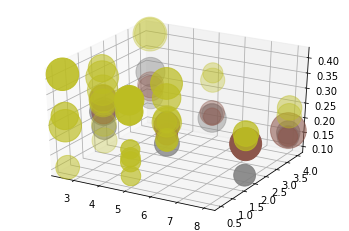

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfm[dfm['Material'] == 'PU']['Força Normal'],
           dfm[dfm['Material'] == 'PU']['Frequência'],
           dfm[dfm['Material'] == 'PU']['COF Médio'],
           color = 'C8',
           s = 16000 * (dfm[dfm['Material'] == 'PU']['COF Desv. Pad.'] / 0.4)
          )
ax.scatter(dfm[dfm['Material'] == 'PUEG1']['Força Normal'],
           dfm[dfm['Material'] == 'PUEG1']['Frequência'],
           dfm[dfm['Material'] == 'PUEG1']['COF Médio'],
           color = 'C7',
           s = 16000 * (dfm[dfm['Material'] == 'PUEG1']['COF Desv. Pad.'] / 0.4)
          )
ax.scatter(dfm[dfm['Material'] == 'PUEG2']['Força Normal'],
           dfm[dfm['Material'] == 'PUEG2']['Frequência'],
           dfm[dfm['Material'] == 'PUEG2']['COF Médio'],
           color = 'C5',
           s = 16000 * (dfm[dfm['Material'] == 'PUEG2']['COF Desv. Pad.'] / 0.4) 
          )

plt.show()

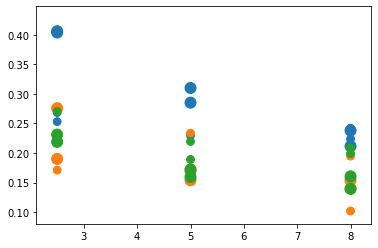

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(dfm[(dfm['Material'] == 'PU') & (dfm['Distância'] == 30)]['Força Normal'],
           dfm[(dfm['Material'] == 'PU') & (dfm['Distância'] == 30)]['COF Médio'],
           color = 'C0',
           s = 1 + 30 * dfm[(dfm['Material'] == 'PU') & (dfm['Distância'] == 30)]['Frequência']
          )
ax.scatter(dfm[dfm['Material'] == 'PUEG1']['Força Normal'],
           dfm[dfm['Material'] == 'PUEG1']['COF Médio'],
           color = 'C1',
           s = 1 + 30 * dfm[dfm['Material'] == 'PUEG1']['Frequência']
          )
ax.scatter(dfm[dfm['Material'] == 'PUEG2']['Força Normal'],
           dfm[dfm['Material'] == 'PUEG2']['COF Médio'],
           color = 'C2',
           s = 1 + 30 * dfm[dfm['Material'] == 'PUEG2']['Frequência']
          )